# COGS 108 - Health Inspection Scores by Zip Code and their Correlation to COVID-19

# Overview

So far, 2020 has been a whirlwind of a year thus far, I thought it would be best include the analysis of COVID-19 in my project. Because this is a topic that is new and relatively unexplored I thought it would be the most interesting thing to carry out this project on. In addition to this, understanding how the food industry might affect the spread of COVID-19 could be really powerful information that may help curb the spread of this pandemic. Thus, the final goal of this project is to determine any positive or negative correlations between health inspections and the spread of COVID-19 in those areas with low inspection scores.

# Name & PID

- Name: Jack Giddings
- PID: A12785560

# Research Question

Do lower scoring health inspection ratings and/or frequency of inspections correlate to lower income cities of North Carolina? Does this have an effect on the number of COVID-19 cases within that area?

## Background and Prior Work

During the current COVID-19 pandemic that we are also experiencing, the health and safety of a community are now its top priority. Food safety has become increasingly common as people disinfect their groceries as soon as they get home. In this time, ensuring health inspections are being carried out properly and to the correct standards is critical to public safety and halting the spread of germs. This begs us to look for ways to improve health inspections and ask questions about the relationships between inspection ratings and the number of COVID cases per neighborhood in LA County. Do worse health inspection ratings correlate to a higher number of cases in a specific neighborhood?
    
In LA County, health inspections are carried out on a rating scale of 1 to 100. A business starts with the full 100 points and is then deducted points depending on the severity of each infraction found during the inspection. Depending on its score it is then issued a grade of A for 90-100, B for 80-89, C for 70-79, and a Fail for anything below a 70. The three levels of violations are minor, major, and critical with any critical violation resulting in an automatic fail regardless of the score [1]. Because the COVID-19 outbreak has occurred so recently there are no prior projects on this topic, though there are a few that are similar. One project looks at Yelp ratings for restaurants in neighborhoods around Toronto to see if lower income neighborhoods have worse service, and therefore worse ratings [2]. This is similar to my question as the number of COVID cases is also broken down by neighborhoods in Los Angeles to analyze any possible correlation. Although this project determined that there is no correlation between Yelp ratings and neighborhood income, this does not discount possible relationships between neighborhood income and health inspection ratings. As such neighborhood income might have an unseen effect on health inspections and thus an unseen effect on the spread of COVID-19.

The second project I found is more directly related to my question as they used the Yelp Health Inspection System, called LIVES, to analyze and identify specific regions of San Francisco with high numbers of health violations [3]. This project did not correlate to neighborhood income, however, but instead has higher violations coming from more high-trafficked areas around SF. My question takes this one step further by asking how LA County neighborhoods with higher frequencies and severities of health inspection infractions affect the spread of COVID-19. 

References (include links):
- 1) http://publichealth.lacounty.gov/eh/misc/ehpost.htm
- 2) https://medium.com/swlh/is-there-a-correlation-between-a-restaurants-ratings-and-the-income-levels-of-a-neighborhood-5fe41165e4f1
- 3) https://nycdatascience.com/blog/student-works/san-francisco-restaurant-inspection-analysis-visualization/

# Hypothesis


I believe that lower health inspection scores does in fact correlate to lower income neighborhoods, which results in a higher number of COVID-19 cases for those areas. Because the COVID-19 virus can live on surfaces, it serves to think that restaurants with worse health inspection ratings are not as clean and might therefore be contributing more heavily to the spread of the virus. If this is true then it would explain a higher number of cases in those neighborhoods, which I predict to be lower income neighborhoods.

# Dataset(s)

- Dataset Name: violations.csv
- Link to the dataset: https://raw.githubusercontent.com/jrgiddin/individual_sp20/master/violations.csv
- Number of observations: 189,803

- Dataset Name: inspections.csv
- Link to the dataset: https://raw.githubusercontent.com/jrgiddin/individual_sp20/master/inspections.csv
- Number of observations: 18,467

- Dataset Name: zipcodes.csv
- Link to the dataset: https://raw.githubusercontent.com/jrgiddin/individual_sp20/master/zipcodes.csv
- Number of observations: 39

- Dataset Name: NC_COVID_Data.csv
- Link to the dataset: https://raw.githubusercontent.com/jrgiddin/individual_sp20/master/NC_COVID_Data.csv
- Number of observations: 780

The violations.csv dataset contains a list of all health code violations for the state of North Carolina from 2012-2016 while the inspections.csv dataset contains the scores of all the health code inspections done from 2012-2016. The zipcodes.csv dataset contains financial information, median household income etc., of thirty-nine (39) cities in NC while the NC_COVID_Data.csv file contains the number of COVID-19 cases and deaths by zipcode. To get these different datasets into one usable dataframe, I will merge the violations.csv and inspections.csv datasets on their 'hsisd' columns. I will then do an inner merge with zipcodes.csv and NC_COVID_Data.csv on their 'zipcode' columns.

# Setup

In [1]:
# All imports used in the project
%matplotlib inline

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
from scipy.stats import pearsonr

# Data Cleaning

Of the five datasets given, two (2) of them were used along with North Carolina's COVID-19 Database (organized by zip) taken from the state government website [4]. Thankfully, my problem required the data to be in a CSV-format, which was given to us in this project. In order to clean the data effectively, columns holding NaN values in 90% or more of their observations were removed from all datasets. From this, only the desired columns necessary for analysis were picked for the dataset and all other were removed. After this, to enable a clean merge, the zip code column was renamed to 'zip' universally.

References:
4) https://covid19.ncdhhs.gov/dashboard/about-data

In [2]:
# Read in all databases given
inspections_db = pd.read_csv("https://raw.githubusercontent.com/jrgiddin/individual_sp20/master/inspections.csv", sep = ',')
zipcode_db = pd.read_csv("https://raw.githubusercontent.com/jrgiddin/individual_sp20/master/zipcodes.csv", sep = ',')
covid_db = pd.read_csv("https://raw.githubusercontent.com/jrgiddin/individual_sp20/master/NC_COVID_Data.csv", sep = ',')

In [3]:
# Drop columns that have NaN values greater than 90% of the time
inspections_db = inspections_db.dropna(thresh = len(inspections_db) * 0.9, axis = 'columns')
zipcode_db.dropna(thresh = len(zipcode_db) * 0.9, axis = 'columns')

# Retrieve only the necessary columns from inspections and rename ZIP Code column in COVID data
inspections_db = inspections_db[['hsisid', 'date', 'zip', 'inspection_num', 'score']]
covid_db = covid_db.rename({'ZIP Code' : 'zip'}, axis = 1)

It was noticed that the lowest health rating score given was 72.5 so scores were standardized with this being the lowest score and 100 being the highest. To do this I wrote a simple python script that turns the score into a float value between 1 and 10. I then applied this function to each observation in the inspections database and set their output value to a new 'standard_score' column.

In [4]:
# Standardize Scores for Health Inspection Ratings
def standardize_scores(score):
    return 1+(((score-72.5)/ 27.5)*9)

inspections_db['standard_score'] = inspections_db['score'].apply(standardize_scores)
inspections_db 

,hsisid,date,zip,inspection_num,score,standard_score
0,4092013748,2012-09-21T00:00:00Z,27610,1,96.0,8.690909
1,4092014046,2012-09-21T00:00:00Z,27610,1,98.0,9.345455
2,4092015191,2012-09-21T00:00:00Z,27610,1,97.0,9.018182
3,4092016122,2012-09-21T00:00:00Z,27513,1,99.0,9.672727
4,4092021513,2012-09-21T00:00:00Z,27597,1,97.0,9.018182
...,...,...,...,...,...,...
18461,4092021142,2016-11-03T00:00:00Z,27616,10,93.0,7.709091
18462,4092110100,2016-11-03T00:00:00Z,27513,9,97.0,9.018182
18463,4092110487,2016-11-03T00:00:00Z,27519,9,96.0,8.690909
18464,4092300177,2016-11-03T00:00:00Z,27603,10,99.0,9.672727


# Data Analysis & Results

### EDA 
Looking at the scatterplot that gives the distribution of all health inspection scores for each zip code in North Carolina it can be seen that it stays fairly consistent for almost all zipcodes across the data that was given. I hypothesized that zip codes with lower scores would correlate to lower income neighborhoods and vice versa. In addition, I also hypothesized that lower scores would correlate to a higher number of COVID-19 cases in that area. As the dataframe we were given contained many gaps between zipcodes, the distributions computed below were determined after removing outliers. Besides this though there is no immediate clear trend from the scores when correlated to zip code. 

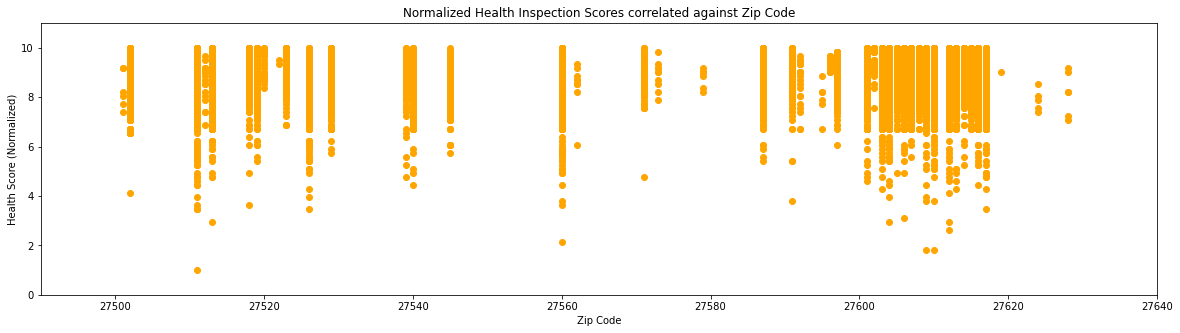

In [5]:
#Graph 1
plt.figure(figsize = (20, 5))
plt.scatter(inspections_db['zip'], inspections_db['standard_score'], color = 'orange')
plt.title("Normalized Health Inspection Scores correlated against Zip Code")
plt.xlabel("Zip Code")
plt.ylabel("Health Score (Normalized)")
plt.ylim(0, 11)
plt.xlim(27490, 27640)
plt.show()

This graph displays all the health inspection scores grouped according to their respective zip codes. A pearson correlation is completed in order to normalize the covariance between our Zip Codes and Standard Scores. A correlation of 0.5-1.0 is significant while anything lower than 0.5 is seen as insignificant. From the tests run below, it seems that zip code doesn't have any correlation towards the health scores their respective area receives. 

In [6]:
# Check Pearson Correlation
correlation, _ = pearsonr(inspections_db.zip, inspections_db.standard_score)
print("Pearson Correlation is: " + str(correlation))

Pearson Correlation is: 0.02350884079287179


Grouping the data by zip code allows us to find the median of the data for each zip code. Once this is found we can create another scatterplot that may make it easier to see any differences in health ratings between the different zip codes. 

In [7]:
mean_insp_scores_db = inspections_db.groupby('zip').median()
mean_insp_scores_db.head()

,hsisid,inspection_num,score,standard_score
zip,,,,
27501,4.092017e+09,3.5,94.25,8.118182
27502,4.092017e+09,4.0,96.50,8.854545
27511,4.092016e+09,4.0,97.50,9.181818
27512,4.092026e+09,3.5,96.25,8.772727
27513,4.092016e+09,4.0,96.00,8.690909


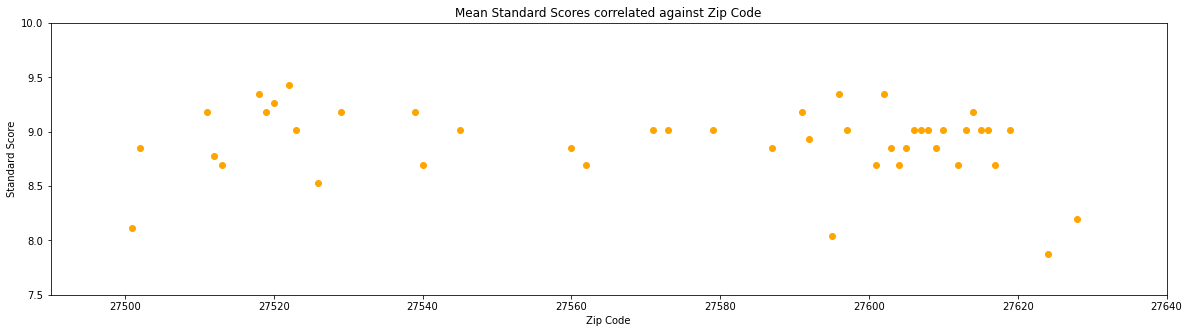

In [8]:
#Graph 2
plt.figure(figsize = (20, 5))
plt.scatter(mean_insp_scores_db.index, mean_insp_scores_db['standard_score'], color = 'orange')
plt.title("Mean Standard Scores correlated against Zip Code")
plt.xlabel("Zip Code")
plt.ylabel("Standard Score")
plt.ylim(7.5, 10)
plt.xlim(27490, 27640)
plt.show()

Looking at it visually, except for a few outliers towards the beginning and the end of the graph, it doesn't seem like scores have a trend or any correlation towards zip codes. It seems clearer than last time and might be a stronger correlation, but probably not by much. Running a Pearson correlation on the set allows us to detrmine that there is now a stronger correlation from score to zip code but not by much. Overall they are still an insignificant correlation. 

In [9]:
# Check Pearson Correlation
correlation2, _ = pearsonr(mean_insp_scores_db.index, mean_insp_scores_db.standard_score)
print("Pearson Correlation is: " + str(correlation2))

Pearson Correlation is: 0.24121165082943846


In [10]:
zip_covid_db = pd.merge(zipcode_db, covid_db, on = 'zip', how = 'inner')
zip_covid_db = zip_covid_db[['zip','per_capita_income_dollars', 'Cases', 'Deaths']]

A standardize_income function is written so that a comparison between per capita income and COVID-19 cases can be made.

In [11]:
def standardize_income(income):
    return 1+(((income-17363)/ 41792)* 9)
zip_covid_db['standard_income'] = zip_covid_db['per_capita_income_dollars'].apply(standardize_income)
zip_covid_db

,zip,per_capita_income_dollars,Cases,Deaths,standard_income
0,27501,21631,41,1,1.919123
1,27502,36763,82,1,5.177833
2,27511,33139,69,2,4.397397
3,27513,41232,65,1,6.140242
4,27518,49865,22,0,7.999378
5,27519,45778,49,2,7.119233
6,27520,25628,168,16,2.779886
7,27522,25513,61,0,2.755121
8,27523,36976,13,0,5.223703
9,27526,28074,45,0,3.306638


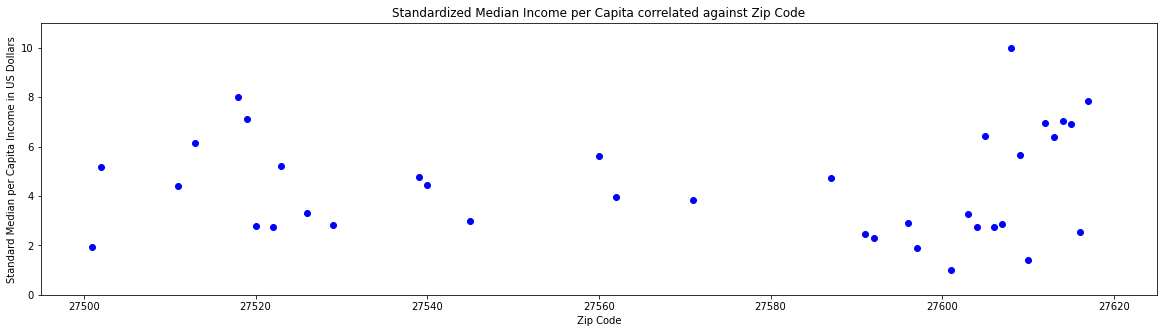

In [12]:
#Graph 3
plt.figure(figsize = (20, 5))
plt.scatter(zip_covid_db['zip'], zip_covid_db['standard_income'], color = 'blue')
plt.title("Standardized Median Income per Capita correlated against Zip Code")
plt.xlabel("Zip Code")
plt.ylabel("Standard Median per Capita Income in US Dollars")
plt.ylim(0, 11)
plt.xlim(27495, 27625)
plt.show()

This graph displays the normalized median per capita income in correlation to North Carolina zip codes. 

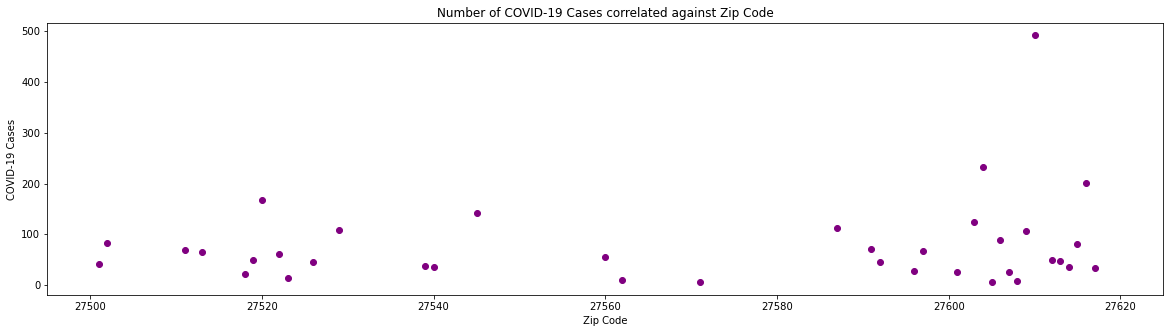

In [13]:
#Graph 4
plt.figure(figsize = (20, 5))
plt.scatter(zip_covid_db['zip'], zip_covid_db['Cases'], color = 'purple')
plt.title("Number of COVID-19 Cases correlated against Zip Code")
plt.xlabel("Zip Code")
plt.ylabel("COVID-19 Cases")
plt.xlim(27495, 27625)
plt.show()

This graph displays the number of cases corresponding to the given area codes as a way to compare normalized income to the number of COVID-19 cases.

### Analysis

From looking at these two graphs it can be seen that the relationship for the number of COVID-19 cases to zip code is inverse to that for median income per capita. For example, a few points that show this fact are the numbers values from each table for the zip codes 27520, 27540, & 27560. The normalized median income for these zip codes are 2, 4.5, & 5.5, respectively, while the cases for these areas are ~175, ~40, & ~60. The zip with the lowest median per capita income also has the largest number of COVID-19 cases BY FAR. This pattern is widespread when comparing these two graphs further and serves to show that COVID-19 cases are more prevalent in lower income neighborhoods despite not having any correlation to the public food safety of that area.

# Ethics & Privacy

Data collection for this question is ethical as health inspection records and the number of COVID cases broken down by the state, county, and zip code level are all public knowledge and record. Databases such as LIVES from Yelp will not be used for this project as its system interprets self-reported scores and does not take scores directly from the public data base for health inspections. We won't be using the LIVES database as it may include some bias towards those who self-reported higher scores than are accurate. In order to protect people's anonymity, owner names will not be collected. As all the data we are using is public knowledge and record, there are no privacy issues involved with gathering this data and so no data retention or data security plans need to be made. For analysis, we will be taking the entire summarized dataset of each neighborhood to find relationships. As such, so there should be no implicit biases within the datasets themselves because everything is public knowledge and the entire process is very well documented/auditable if issues are discovered in the future. None of the variables that will be used in modeling the data are unfairly discriminatory. The dataset as a whole is very diverse and does not have any privacy issues so I do not expect there to any ethical or privacy issues.

# Conclusion & Discussion

The ultimate goal of this project was to determine if there are any correlations between health inspection scores and the number of COVID-19 cases when grouped according to zip code. In order to do this I also analyzed the relationship between median income per capita and its resulting relationships towards health inspection ratings and COVID-19 cases. Both the zip code data and the health inspections data was given to me for the project and was limited to zip codes within North Carolina. As a result, the COVID-19 web data was also exclusively pulled from the NC State COVID-19 database in order to accurately merge with the zip code dataset. 
The first graph visualizing health inspection scores grouped to their zip codes showed that there was no significant correlation between inspection scores and the zip codes in which they are grouped. What this tells us is that inspection scores do not show significant bias towards one zip code or the another, as well as and going against the hypothesis that lower inspection scores correlate towards lower income neighborhoods. The second graph elaborated on this fact further by showing a stronger correlation but nothing even close to significant. Unfortunately, this strongly disproves my hypothesis that health inspection scores have any correlation towards the median income of a neighborhood. To determine if a correlation exists between COVID-19 cases and median income, however, I first standardized all median income per capita and plotted the third graph to show their normalized trend. After this I did the same with COVID-19 cases and compared the two trends to find that they actually held an inverse relationship. Although it doesn't appear as an explicit rule, it shows that the zip codes with the lowest median income had some of the highest number of COVID-19 cases, while areas with high median income has some of the lower numbers of COVID-19 cases. 
As a whole, this experiment would ideally include data from every state across the country. It could be such that North Carolina doesn't show any patterns but maybe another state might? From the small amount of data that I had access to I was able to draw some fairly strong correlations between median income and COVID-19 cases so adding more data to the set should serve only to strengthen those correlations. This question is crucial to society as identifying the communities impacted the most is crucial towards understanding the movement of the virus. Due the the social issues that have long been a problem but are only now being discussed, such findings could be linked as another result of longstanding systematic racism. Such findings could have the power to curb the COVID-19 virus AND instigate major societal change.

P.S. Thanks for an amazing quarter!